<a href="https://colab.research.google.com/github/Mc4minta/AIB5-PcapAttackClassifier/blob/main/AttackClassifyLGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AttackClassify

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import pandas as pd
import numpy as np
import os

csv_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/GeneratedLabelledFlows/TrafficLabelling'

csv_files = [
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',     # Benign, DDOS,
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', # Benign, Portscan
    'Monday-WorkingHours.pcap_ISCX.csv',                    # Benign
    'Tuesday-WorkingHours.pcap_ISCX.csv',                   # Benign, FTP, SSH
    'Wednesday-workingHours.pcap_ISCX.csv',                 # Benign, DOSs, Heartbleed

    #'Thursday-WorkingHours-Morning-WebAttacks-Fix.pcap_ISCX.csv' # Benign, Web attacks (Fixed)

    # 'Friday-WorkingHours-Morning.pcap_ISCX.csv',          # Benign, Bot
    # 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv' # Benign, Web attacks
    # 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', # Benign, Infiltration
]

dfs = []

for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    try:
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip().str.replace(' ', '_')  # Clean column names

        if 'Label' not in df.columns:
            print(f"Label column missing in: {file}")
            continue

        # Drop 65% of BENIGN samples
        benign_df = df[df['Label'] == 'BENIGN']
        non_benign_df = df[df['Label'] != 'BENIGN']

        # Drop 65% of BENIGN samples randomly
        dropped_benign = benign_df.sample(frac=0.35, random_state=42)

        # Concatenate back with attack samples
        reduced_df = pd.concat([dropped_benign, non_benign_df], ignore_index=True)

        dfs.append(reduced_df)
        print(f"Loaded and reduced BENIGN in: {file}")

    except FileNotFoundError:
        print(f"File not found: {file}")
    except Exception as e:
        print(f"Error with {file}: {e}")

# Combine all files
df = pd.concat(dfs, ignore_index=True)

# Drop unneeded columns
columns_to_drop = [
    'Flow_ID', 'Source_IP', 'Destination_IP', 'Protocol', 'Timestamp', 'Fwd_Header_Length.1',
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Clean infinite or missing values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

df.head()

Loaded and reduced BENIGN in: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Loaded and reduced BENIGN in: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Loaded and reduced BENIGN in: Monday-WorkingHours.pcap_ISCX.csv
Loaded and reduced BENIGN in: Tuesday-WorkingHours.pcap_ISCX.csv
Loaded and reduced BENIGN in: Wednesday-workingHours.pcap_ISCX.csv


,Source_Port,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,80,40474,7182757,1,5,6.0,30.0,6.0,6.0,6.0,...,20,45201.000,0.000,45201.0,45201.0,7137556.0,0.00,7137556.0,7137556.0,BENIGN
1,80,28907,938509,1,5,6.0,30.0,6.0,6.0,6.0,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
2,0,0,119995732,123,0,0.0,0.0,0.0,0.0,0.0,...,0,3753432.167,5183854.063,13200000.0,1.0,13100000.0,6507819.26,26300000.0,6484077.0,BENIGN
3,58168,443,142954,10,6,553.0,3949.0,196.0,0.0,55.3,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
4,80,17541,2548725,1,6,6.0,36.0,6.0,6.0,6.0,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN


In [15]:
columns_mapping = {
    'Src_Port': 'Source_Port',
    'Dst_Port': 'Destination_Port',
    'Flow_Duration': 'Flow_Duration',
    'Tot_Fwd_Pkts': 'Total_Fwd_Packets',
    'Tot_Bwd_Pkts': 'Total_Backward_Packets',
    'TotLen_Fwd_Pkts': 'Total_Length_of_Fwd_Packets',
    'TotLen_Bwd_Pkts': 'Total_Length_of_Bwd_Packets',
    'Fwd_Pkt_Len_Max': 'Fwd_Packet_Length_Max',
    'Fwd_Pkt_Len_Min': 'Fwd_Packet_Length_Min',
    'Fwd_Pkt_Len_Mean': 'Fwd_Packet_Length_Mean',
    'Fwd_Pkt_Len_Std': 'Fwd_Packet_Length_Std',
    'Bwd_Pkt_Len_Max': 'Bwd_Packet_Length_Max',
    'Bwd_Pkt_Len_Min': 'Bwd_Packet_Length_Min',
    'Bwd_Pkt_Len_Mean': 'Bwd_Packet_Length_Mean',
    'Bwd_Pkt_Len_Std': 'Bwd_Packet_Length_Std',
    'Flow_Byts/s': 'Flow_Bytes/s',
    'Flow_Pkts/s': 'Flow_Packets/s',
    'Flow_IAT_Mean': 'Flow_IAT_Mean',
    'Flow_IAT_Std': 'Flow_IAT_Std',
    'Flow_IAT_Max': 'Flow_IAT_Max',
    'Flow_IAT_Min': 'Flow_IAT_Min',
    'Fwd_IAT_Tot': 'Fwd_IAT_Total',
    'Fwd_IAT_Mean': 'Fwd_IAT_Mean',
    'Fwd_IAT_Std': 'Fwd_IAT_Std',
    'Fwd_IAT_Max': 'Fwd_IAT_Max',
    'Fwd_IAT_Min': 'Fwd_IAT_Min',
    'Bwd_IAT_Tot': 'Bwd_IAT_Total',
    'Bwd_IAT_Mean': 'Bwd_IAT_Mean',
    'Bwd_IAT_Std': 'Bwd_IAT_Std',
    'Bwd_IAT_Max': 'Bwd_IAT_Max',
    'Bwd_IAT_Min': 'Bwd_IAT_Min',
    'Fwd_PSH_Flags': 'Fwd_PSH_Flags',
    'Bwd_PSH_Flags': 'Bwd_PSH_Flags',
    'Fwd_URG_Flags': 'Fwd_URG_Flags',
    'Bwd_URG_Flags': 'Bwd_URG_Flags',
    'Fwd_Header_Len': 'Fwd_Header_Length',
    'Bwd_Header_Len': 'Bwd_Header_Length',
    'Fwd_Pkts/s': 'Fwd_Packets/s',
    'Bwd_Pkts/s': 'Bwd_Packets/s',
    'Pkt_Len_Min': 'Min_Packet_Length',
    'Pkt_Len_Max': 'Max_Packet_Length',
    'Pkt_Len_Mean': 'Packet_Length_Mean',
    'Pkt_Len_Std': 'Packet_Length_Std',
    'Pkt_Len_Var': 'Packet_Length_Variance',
    'FIN_Flag_Cnt': 'FIN_Flag_Count',
    'SYN_Flag_Cnt': 'SYN_Flag_Count',
    'RST_Flag_Cnt': 'RST_Flag_Count',
    'PSH_Flag_Cnt': 'PSH_Flag_Count',
    'ACK_Flag_Cnt': 'ACK_Flag_Count',
    'URG_Flag_Cnt': 'URG_Flag_Count',
    'CWE_Flag_Count': 'CWE_Flag_Count',
    'ECE_Flag_Cnt': 'ECE_Flag_Count',
    'Down/Up_Ratio': 'Down/Up_Ratio',
    'Pkt_Size_Avg': 'Average_Packet_Size',
    'Fwd_Seg_Size_Avg': 'Avg_Fwd_Segment_Size',
    'Bwd_Seg_Size_Avg': 'Avg_Bwd_Segment_Size',
    'Fwd_Byts/b_Avg': 'Fwd_Byts/b_Avg',
    'Fwd_Pkts/b_Avg': 'Fwd_Pkts/b_Avg',
    'Fwd_Blk_Rate_Avg': 'Fwd_Blk_Rate_Avg',
    'Bwd_Byts/b_Avg': 'Bwd_Byts/b_Avg',
    'Bwd_Pkts/b_Avg': 'Bwd_Pkts/b_Avg',
    'Bwd_Blk_Rate_Avg': 'Bwd_Blk_Rate_Avg',
    'Subflow_Fwd_Pkts': 'Subflow_Fwd_Pkts',
    'Subflow_Fwd_Byts': 'Subflow_Fwd_Byts',
    'Subflow_Bwd_Pkts': 'Subflow_Bwd_Pkts',
    'Subflow_Bwd_Byts': 'Subflow_Bwd_Byts',
    'Init_Fwd_Win_Byts': 'Init_Fwd_Win_Byts',
    'Init_Bwd_Win_Byts': 'Init_Bwd_Win_Byts',
    'Fwd_Act_Data_Pkts': 'act_data_pkt_fwd',
    'Fwd_Seg_Size_Min': 'Fwd_Seg_Size_Min',
    'Active_Mean': 'Active_Mean',
    'Active_Std': 'Active_Std',
    'Active_Max': 'Active_Max',
    'Active_Min': 'Active_Min',
    'Idle_Mean': 'Idle_Mean',
    'Idle_Std': 'Idle_Std',
    'Idle_Max': 'Idle_Max',
    'Idle_Min': 'Idle_Min'
}


df = df.rename(columns=columns_mapping)
df = df.dropna()
df.head()

,Source_Port,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,80,40474,7182757,1,5,6.0,30.0,6.0,6.0,6.0,...,20,45201.000,0.000,45201.0,45201.0,7137556.0,0.00,7137556.0,7137556.0,BENIGN
1,80,28907,938509,1,5,6.0,30.0,6.0,6.0,6.0,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
2,0,0,119995732,123,0,0.0,0.0,0.0,0.0,0.0,...,0,3753432.167,5183854.063,13200000.0,1.0,13100000.0,6507819.26,26300000.0,6484077.0,BENIGN
3,58168,443,142954,10,6,553.0,3949.0,196.0,0.0,55.3,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN
4,80,17541,2548725,1,6,6.0,36.0,6.0,6.0,6.0,...,20,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,BENIGN


In [16]:
# Remove unused attacks rows
values_to_remove = ['Bot', 'Heartbleed']
df = df[~df['Label'].isin(values_to_remove)]
df = df.reset_index(drop=True)
df['Label'].value_counts()

,count
Label,
BENIGN,569110
DoS Hulk,230124
PortScan,158804
DDoS,128025
DoS GoldenEye,10293
FTP-Patator,7935
SSH-Patator,5897
DoS slowloris,5796
DoS Slowhttptest,5499


In [17]:
# Groupped DOS Labels and rename FTP and SSH to be bruteforce
label_mapping = {
    'DoS Hulk': 'DoS',
    'DDoS': 'DDoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan' : 'PortScan',
    'FTP-Patator': 'FTP-Bruteforce',
    'SSH-Patator': 'SSH-Bruteforce',
}

# Apply the label mapping to the 'Label' column
df['Label'] = df['Label'].map(label_mapping)
df['Label'].value_counts()

,count
Label,
DoS,251712
PortScan,158804
DDoS,128025
FTP-Bruteforce,7935
SSH-Bruteforce,5897


In [18]:
df = df[~((df['Label'] == 'Benign') & df.duplicated())]
df['Label'].value_counts()

,count
Label,
DoS,251712
PortScan,158804
DDoS,128025
FTP-Bruteforce,7935
SSH-Bruteforce,5897


In [19]:
# prompt: compare the count of benigh label row and all other label row combine

benign_count = len(df[df['Label'] == 'Benign'])
other_labels_count = len(df[df['Label'] != 'Benign'])

print(f"Benign: {benign_count}")
print(f"Attack: {other_labels_count}")

Benign: 0
Attack: 1121483


In [20]:
import pandas as pd
from pandas.api.types import CategoricalDtype

# Sample mapping function for ports
def map_port(port):
    if port == 21:
        return 'FTP'
    elif port == 22:
        return 'SSH'
    elif port == 53:
        return 'DNS'
    elif port == 80:
        return 'HTTP'
    elif port == 443:
        return 'HTTPS'
    else:
        return 'Other'

# Apply port mapping
df['Destination_Port'] = df['Destination_Port'].apply(map_port)
df['Source_Port'] = df['Source_Port'].apply(map_port)

# Define port categories
port_categories = ['FTP', 'SSH', 'DNS', 'HTTP', 'HTTPS', 'Other']
port_cat_type = CategoricalDtype(categories=port_categories, ordered=False)

# Convert both columns to categorical
df['Destination_Port'] = df['Destination_Port'].astype(port_cat_type)
df['Source_Port'] = df['Source_Port'].astype(port_cat_type)


In [25]:
df = df.dropna()

In [26]:
df.head()

,Source_Port,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
34193,Other,HTTP,1293792,3,7,26.0,11607.0,20.0,0.0,8.666667,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DDoS
34194,Other,HTTP,4421382,4,0,24.0,0.0,6.0,6.0,6.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DDoS
34195,Other,HTTP,1083538,3,6,26.0,11601.0,20.0,0.0,8.666667,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DDoS
34196,Other,HTTP,80034360,8,4,56.0,11601.0,20.0,0.0,7.000000,...,20,939.0,0.0,939.0,939.0,39300000.0,44200000.0,70600000.0,8072664.0,DDoS
34197,Other,HTTP,642654,3,6,26.0,11607.0,20.0,0.0,8.666667,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DDoS


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 552373 entries, 34193 to 1121482
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Source_Port                  552373 non-null  category
 1   Destination_Port             552373 non-null  category
 2   Flow_Duration                552373 non-null  int64   
 3   Total_Fwd_Packets            552373 non-null  int64   
 4   Total_Backward_Packets       552373 non-null  int64   
 5   Total_Length_of_Fwd_Packets  552373 non-null  float64 
 6   Total_Length_of_Bwd_Packets  552373 non-null  float64 
 7   Fwd_Packet_Length_Max        552373 non-null  float64 
 8   Fwd_Packet_Length_Min        552373 non-null  float64 
 9   Fwd_Packet_Length_Mean       552373 non-null  float64 
 10  Fwd_Packet_Length_Std        552373 non-null  float64 
 11  Bwd_Packet_Length_Max        552373 non-null  float64 
 12  Bwd_Packet_Length_Min        552373 non-null

# LIGHTGBM Multiclass

In [11]:
! pip install lightgbm

In [28]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose df is your dataframe with 'Label' as target and features including 2 categorical columns
X = df.drop('Label', axis=1)
y = df['Label'].astype('category')  # Ensure labels are categorical for multiclass

# Specify your categorical columns explicitly
cat_cols = ['Destination_Port', 'Source_Port']

# Convert categorical columns to category dtype
for col in cat_cols:
    X[col] = X[col].astype('category')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Number of classes
num_classes = y.nunique()

# Initialize LightGBM model for multiclass classification
model = lgb.LGBMClassifier(objective='multiclass', num_class=num_classes)

# Train the model
model.fit(X_train, y_train, categorical_feature=cat_cols)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10249
[LightGBM] [Info] Number of data points in the train set: 441898, number of used features: 65
[LightGBM] [Info] Start training from score -1.462095
[LightGBM] [Info] Start training from score -0.785717
[LightGBM] [Info] Start training from score -4.232908
[LightGBM] [Info] Start training from score -1.246923
[LightGBM] [Info] Start training from score -4.550777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(num_class=5, objective='multiclass')

                precision    recall  f1-score   support

          DDoS       1.00      1.00      1.00     25615
           DoS       1.00      1.00      1.00     50298
FTP-Bruteforce       1.00      1.00      1.00      1523
      PortScan       1.00      1.00      1.00     31808
SSH-Bruteforce       1.00      1.00      1.00      1231

      accuracy                           1.00    110475
     macro avg       1.00      1.00      1.00    110475
  weighted avg       1.00      1.00      1.00    110475



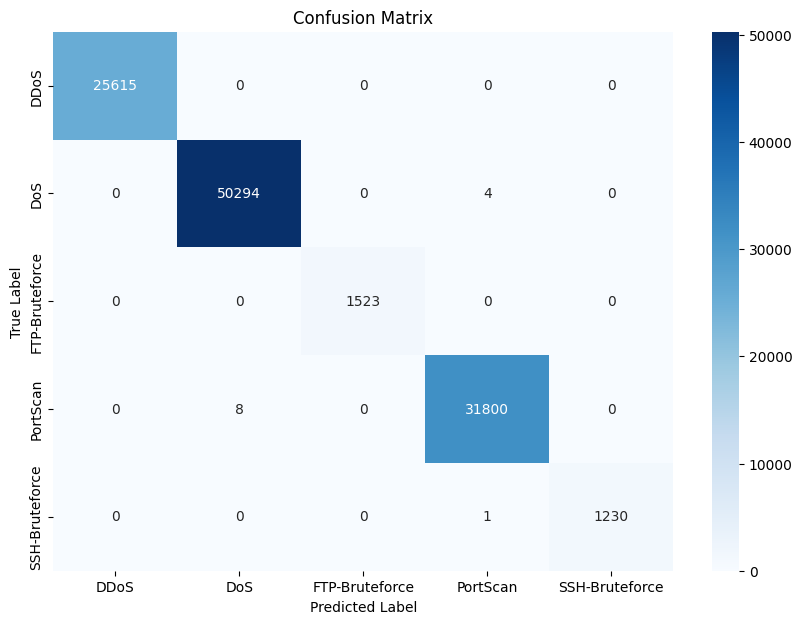

In [29]:
# Predict on test set
y_pred = model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot confusion matrix with seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [30]:
import joblib

# Optional: Save the model using joblib
joblib.dump(model, '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/AttackClassifyLGBM.pkl')

['/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/AttackClassifyLGBM.pkl']